### VaR Comparison

##### Imports & Config

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Fetching stock data

In [3]:
stock_df = pd.read_csv('data/stock_data.csv')

In [4]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True)
stock_df['Date'] = stock_df['Date'].dt.date
stock_df['Date'] = stock_df['Date'].apply(lambda x: dt.datetime.combine(x, dt.time(0, 0)))

In [5]:
def convert_csv_df_to_yf_df(csv_df):
    """Convert a CSV DataFrame to a format similar to Yahoo Finance DataFrame.
    The CSV DataFrame should have 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close', and 'Volume' columns.
    """    

    # Ensure the Date column is of datetime type.
    csv_df['Date'] = pd.to_datetime(csv_df['Date'])

    # Define the price columns that you want to keep.
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Pivot the DataFrame.
    # With a list for values, pivot_table creates a MultiIndex on the columns where the first level is the price fields
    # and the second level is the ticker symbol.
    multi_df = csv_df.pivot_table(index='Date', columns='Ticker', values=price_cols)

    # Optionally, sort the MultiIndex columns.
    multi_df = multi_df.sort_index(axis=1)

    # Set the MultiIndex column names so that the first level is 'Price' and the second is 'Ticker'.
    multi_df.columns.names = ['Price', 'Ticker']

    return multi_df


#### Declaring classes

##### Portofolio Class

In [6]:

class PortofolioData:
    def __init__(self, stocks, weights, Time, initial_investment, forecast_start_date=dt.datetime.now(), yahoo_finance=False):
        self.stocks = stocks
        self.weights = np.array(weights)
        self.Time = Time  # number of days over which the var is calculated
        self.initial_investment = initial_investment
        self.returns, self.mean_returns, self.cov_matrix = self.get_data(
                start_date=forecast_start_date-dt.timedelta(days=800), end_date=forecast_start_date, yahoo_finance=yahoo_finance)

    def get_data(
        self,
        start_date=dt.datetime.now() - dt.timedelta(days=800),
        end_date=dt.datetime.now(),
        yahoo_finance=False,
    ):
        # Get historical data and calculate returns
        if yahoo_finance:
            stock_data = yf.download(self.stocks, start=start_date, end=end_date)
        else:
            stock_data = stock_df[(stock_df['Ticker'].isin(self.stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
            stock_data = convert_csv_df_to_yf_df(stock_data)
        stock_data = stock_data["Close"]
        returns = stock_data.pct_change()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        returns = returns.dropna()
        returns["portofolio"] = returns.dot(self.weights)

        if stock_data.empty:
            raise ValueError("No data found for the selected date range and tickers.")


        return returns, mean_returns, cov_matrix

    def get_expected_portofolio_performance(self):
        expected_returns = np.sum(self.mean_returns * self.weights) * self.Time
        expected_std = np.sqrt(
            np.dot(self.weights.T, np.dot(self.cov_matrix, self.weights))
        ) * np.sqrt(self.Time)
        return expected_returns, expected_std

    def __str__(self):
        txt = ""
        txt += f"PORTOFOLIO: {self.initial_investment}\n"
        for i in range(len(self.stocks)):
            txt += f"{self.stocks[i]}:{self.weights[i]*100}%\n"
        txt += "--------------------------\n"
        txt += "Returns:\n"
        txt += f"{self.returns}\n"
        txt += "--------------------------\n"
        txt += "Mean Returns:\n"
        txt += f"{self.mean_returns}\n"
        txt += "--------------------------\n"
        txt += "Covariance Matrix\n"
        txt += f"{self.cov_matrix}\n"
        txt += "--------------------------\n"
        return txt


##### VaR Class

In [7]:

class prediction:
    def __init__(self, portofolio: PortofolioData, confidence_level=0.95):
        self.portofolio = portofolio
        self.confidence_level = confidence_level
        self.alpha = 1 - confidence_level

    def calculate_historical_var(self):
        h_var = -np.percentile(
            self.portofolio.returns["portofolio"], self.alpha * 100
        ) * np.sqrt(self.portofolio.Time)

        return {
            "relative": h_var,
            "absolute": self.portofolio.initial_investment * h_var,
        }

    def calculate_parametric_var(self):

        expected_portofolio_return, expected_portofolio_std = (
            self.portofolio.get_expected_portofolio_performance()
        )

        p_var = (
            norm.ppf(self.confidence_level) * expected_portofolio_std
            - expected_portofolio_return
        )

        return {
            "relative": p_var,
            "absolute": self.portofolio.initial_investment * p_var,
        }

    def calculate_monte_carlo_var(self, simulations=1000):
        mean_m = np.full(
            shape=(self.portofolio.Time, len(self.portofolio.weights)),
            fill_value=self.portofolio.mean_returns,
        )
        mean_m = mean_m.T

        portfolio_sims = np.full(
            shape=(self.portofolio.Time, simulations), fill_value=0.0
        )

        for m in range(0, simulations):
            Z = np.random.normal(
                size=(self.portofolio.Time, len(self.portofolio.weights))
            )
            L = np.linalg.cholesky(self.portofolio.cov_matrix)
            daily_returns = mean_m + np.inner(L, Z)
            portfolio_sims[:, m] = (
                np.cumprod(np.inner(self.portofolio.weights, daily_returns.T) + 1)
                * self.portofolio.initial_investment
            )

        portResults = pd.Series(portfolio_sims[-1, :])
        kept = np.percentile(portResults, self.alpha * 100)

        absolute_mc_var = self.portofolio.initial_investment - kept
        relative_mc_var = absolute_mc_var / self.portofolio.initial_investment

        return {
            "relative": relative_mc_var,
            "absolute": absolute_mc_var,
        }

    def __str__(self):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

        txt = "Value at Risk (VaR) Analysis:\n"
        txt += f"Confidence Level: {self.confidence_level * 100}%\n"
        txt += f"Historical VaR: {historical_var}\n"
        txt += f"Parametric VaR: {parametric_var}\n"
        txt += f"Monte Carlo VaR: {monte_carlo_var}\n"
        return txt


##### Fetching test portofolios

In [8]:
from generate_random_portfolios import read_portfolios_from_json

test_portfolios = read_portfolios_from_json("data/random_portfolios.json")

In [9]:
tp = test_portfolios[1]
stocks = tp["stocks_list"]
weights = tp["stocks_weights"]
initial_investment = tp['initial_investment']
end_date = dt.datetime.strptime(tp["start_date"], "%Y-%m-%d")
start_date = end_date - dt.timedelta(days=800)


stock_data = stock_df[(stock_df['Ticker'].isin(stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
stock_data = convert_csv_df_to_yf_df(stock_data)

In [10]:
stock_data.head()

Price            Close                                       High              \
Ticker             FDX         JPM   NTDOY         SQ         FDX         JPM   
Date                                                                            
2022-08-29  211.728745  110.906273  10.350  67.750000  213.399291  111.361960   
2022-08-30  208.553741  110.925667  10.286  69.050003  213.936602  112.060033   
2022-08-31  205.945358  110.266380  10.220  68.910004  210.028909  111.526785   
2022-09-01  208.106384  111.022621  10.170  68.750000  208.342137  111.138962   
2022-09-02  205.022018  110.246986  10.060  66.330002  210.611209  113.873083   

Price                                 Low                                 \
Ticker       NTDOY         SQ         FDX         JPM   NTDOY         SQ   
Date                                                                       
2022-08-29  10.424  69.989998  209.784675  110.004596  10.346  67.339996   
2022-08-30  10.398  70.129997  207.703822  109.907641  10.252  66.690002   
2022-08-31  10.400  71.751999  205.564358  109.888251  10.202  68.410004   
2022-09-01  10.224  68.785004  203.303023  108.501805  10.140  65.029999   
2022-09-02  10.200  70.070000  203.558412  109.742826  10.054  65.900002   

Price             Open                                    Volume              \
Ticker             FDX         JPM   NTDOY         SQ        FDX         JPM   
Date                                                                           
2022-08-29  211.210976  110.528151  10.400  67.589996  1213000.0   8117300.0   
2022-08-30  213.301593  111.497695  10.398  68.599998  1420400.0  10745400.0   
2022-08-31  209.481819  110.993539  10.376  70.589996  1718200.0  10738300.0   
2022-09-01  205.739080  109.839775  10.200  67.430000  1582400.0   9979800.0   
2022-09-02  210.404923  112.341208  10.170  69.830002  1422700.0  10666600.0   

Price                              
Ticker          NTDOY          SQ  
Date                               
2022-08-29  1350500.0   9590900.0  
2022-08-30  1007000.0  11902000.0  
2022-08-31   608000.0  10039200.0  
2022-09-01   872500.0  11949600.0  
2022-09-02   900000.0  12389900.0

#### Comparing the VaR methods

##### Getting daily returns

In [11]:
# Get returns for each portofolio
returns = []
portofolios = []

for test_portfolio in test_portfolios:

    test_portfolio["start_date"] = dt.datetime.strptime(test_portfolio["start_date"], "%Y-%m-%d")

    portofolio = PortofolioData(
        stocks=test_portfolio["stocks_list"],
        weights=test_portfolio["stocks_weights"],
        Time=test_portfolio["time"],
        initial_investment=test_portfolio["initial_investment"],
        forecast_start_date=  test_portfolio["start_date"],
        yahoo_finance=False,
    )
    portofolios.append(portofolio)
    

    ret, mean_ret, cov_matrix = portofolio.get_data(
        test_portfolio["start_date"], 
        test_portfolio["start_date"] + dt.timedelta(days=test_portfolio["time"])
    )

    returns.append(ret)


In [12]:

def show_portfolio_distribution(returns, quantile = 0.05):
    sns.histplot(returns, bins=30, kde=True)

    quantile_mark = returns.quantile(quantile)  
    plt.axvline(quantile_mark, color='red', linestyle='dashed', label=f'95% Quantile: {quantile_mark:.4f}')

    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution')
    plt.legend()
    plt.show()

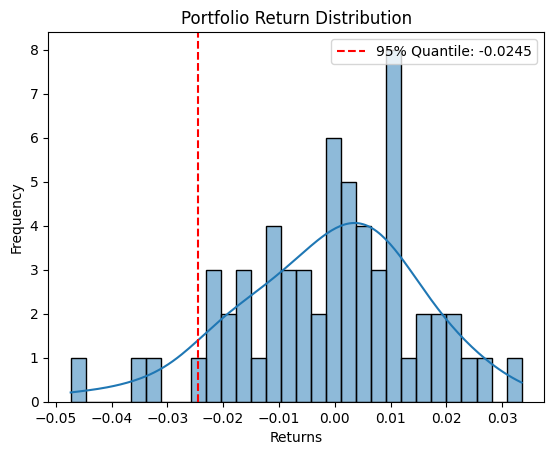

In [13]:
show_portfolio_distribution(returns[2]['portofolio'])

In [14]:
def compare_portfolio_distributions(forecast_returns, historic_returns, label1="Returns to Forecast", label2="Past historical Returns", quantile=0.05):
    plt.figure(figsize=(10, 6))
    
    # Plot both distributions
    sns.histplot(forecast_returns, bins=30, kde=True, color='blue', label=label1, stat="density", alpha=0.6)
    sns.histplot(historic_returns, bins=30, kde=True, color='orange', label=label2, stat="density", alpha=0.6)

    # Calculate quantiles
    q1 = forecast_returns.quantile(quantile)
    q2 = historic_returns.quantile(quantile)

    # Add vertical lines at quantiles
    plt.axvline(q1, color='blue', linestyle='dashed', label=f'{label1} {int(quantile*100)}% Quantile: {q1:.4f}')
    plt.axvline(q2, color='orange', linestyle='dashed', label=f'{label2} {int(quantile*100)}% Quantile: {q2:.4f}')
    
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.title('Comparison of Portfolio Return Distributions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

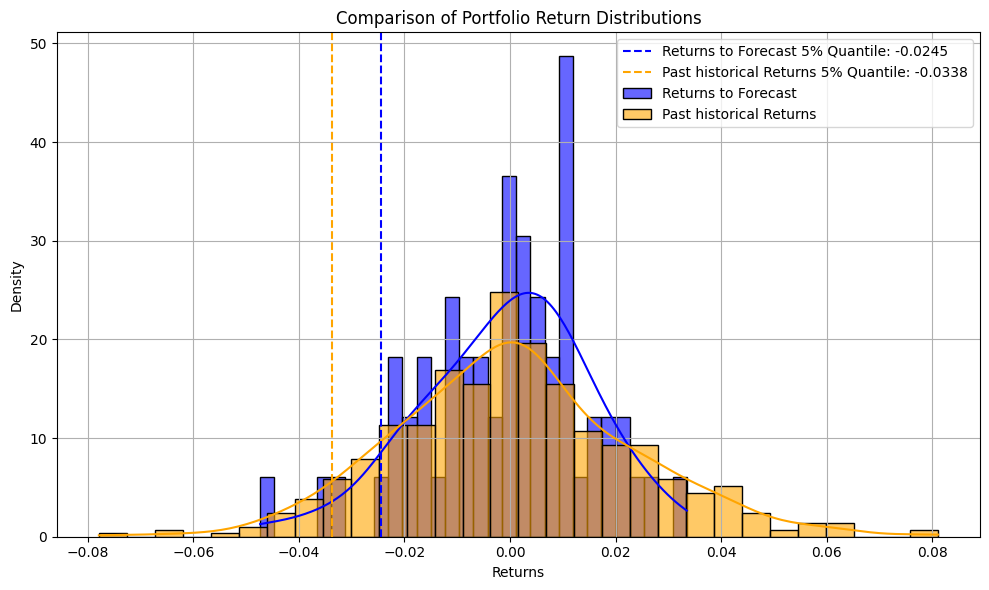

In [15]:
index = 2

compare_portfolio_distributions(returns[2]['portofolio'],portofolios[index].returns['portofolio'])

In [16]:
values_at_risk = []
for portofolio in portofolios:
    try:
        var = prediction(portofolio, confidence_level=0.95)

        values_at_risk.append(
            {
                "historical": -var.calculate_historical_var()['relative'],
                "parametric": -var.calculate_parametric_var()['relative'],
                "monte_carlo": -var.calculate_monte_carlo_var()['relative'],
            }
        )
    except:
        print('VaR could not be calculated')

In [17]:


def show_portfolio_distribution_with_vars(returns, var_dict, time_horizon=1, quantile=0.05, ):
    # Plot the distribution with histogram and KDE
    returns = returns * np.sqrt(time_horizon)  # Scale returns for the time horizon
    sns.histplot(returns, bins=50, kde=True)
    
    # Plot the base quantile (for reference)
    base_quantile = returns.quantile(quantile)
    plt.axvline(base_quantile, color='black', 
                label=f'{quantile*100:.0f}% Quantile of Returns: {base_quantile:.4f}')
    
    # Define a unique color for each VaR method
    colors = {
        "historical": "red",
        "parametric": "blue",
        "monte_carlo": "green"
    }
    
    # Plot a vertical line for each VaR method
    for method, var_value in var_dict.items():
        plt.axvline(var_value, color=colors.get(method, "gray"), linestyle='dashed', 
                    label=f'{method.capitalize()} VaR: {var_value:.4f}')
    
    # Determine the range to zoom in on the vertical lines
    # Get minimum and maximum of base quantile and all VaR values
    values = [base_quantile] + list(var_dict.values())
    min_val, max_val = min(values), max(values)
    
    # Calculate margin: you can adjust this multiplier to zoom in/out as desired
    margin = (max_val - min_val) * 0.5  
    plt.xlim(min_val - margin, max_val + margin)
    
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution with VaR Estimates')
    plt.legend()
    plt.show()



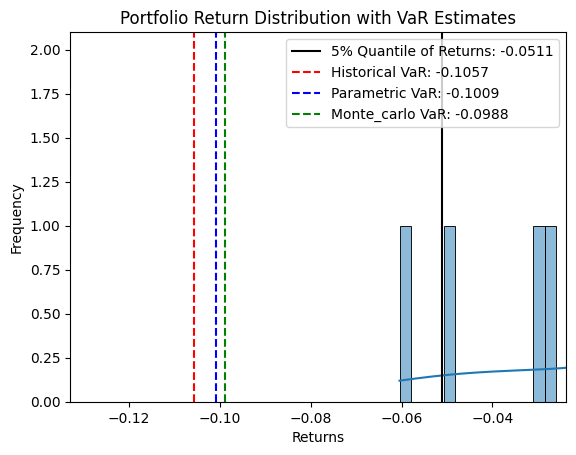

In [18]:
min_index = 4
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'][:], values_at_risk[min_index], time_horizon=portofolios[min_index].Time, quantile=0.05)

##### RMSE

For our chosen way of comparing the models, we will pick the root square mean deviation (RMSE).

In [19]:
def root_mean_squared_error(prediction, truth):
    return np.sqrt(np.mean((prediction - truth) ** 2))

In [20]:
rmses = []

for i in range(len(values_at_risk)):
    truth = returns[i]['portofolio'].quantile(0.95)
    historical_var = values_at_risk[i]['historical']
    parametric_var = values_at_risk[i]['parametric']
    monte_carlo_var = values_at_risk[i]['monte_carlo']

    rmses.append(
        {
            "historical": root_mean_squared_error(historical_var, truth),
            "parametric": root_mean_squared_error(parametric_var, truth),
            "monte_carlo": root_mean_squared_error(monte_carlo_var, truth),
        }
    )

In [21]:
returns[0]['portofolio'].quantile(0.05)

np.float64(-0.022444292709804557)

In [22]:
values_at_risk[0]['historical']

np.float64(-0.23744072743538386)

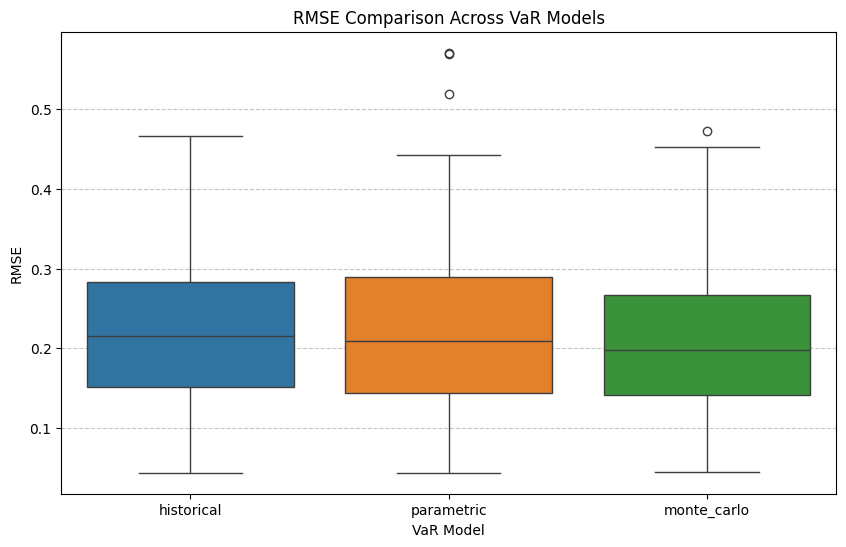

In [23]:
rmse_df = pd.DataFrame(rmses)

# Plot the RMSE values
plt.figure(figsize=(10, 6))
sns.boxplot(data=rmse_df)

plt.title("RMSE Comparison Across VaR Models")
plt.ylabel("RMSE")
plt.xlabel("VaR Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [24]:
len(rmse_df)

100

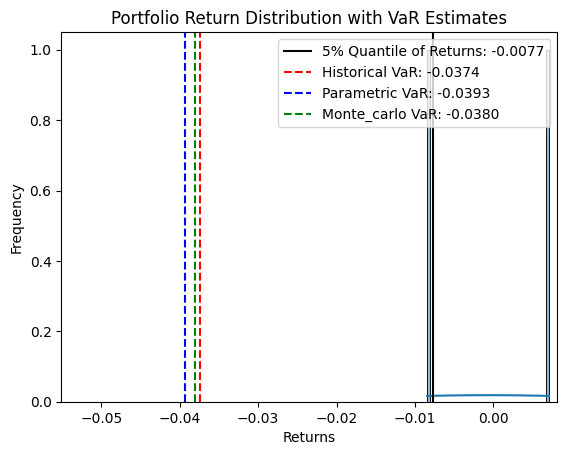

In [25]:
min_index = rmse_df['historical'].idxmin()
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'], values_at_risk[min_index], quantile=0.05)

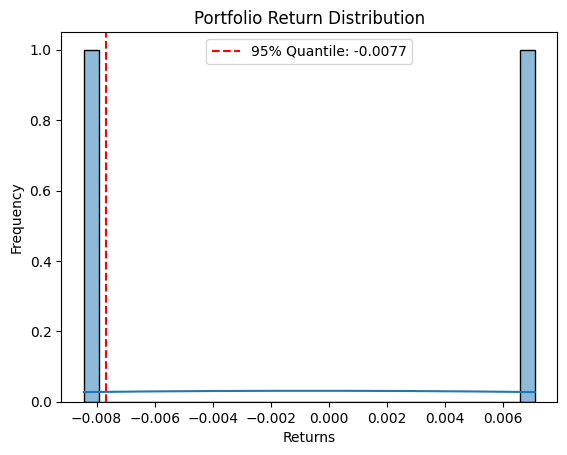

In [26]:
show_portfolio_distribution(returns[min_index]['portofolio'], quantile=0.05)

In [27]:
test_portfolios[min_index]

{'stocks_list': ['PINS',
  'NTDOY',
  'HLT',
  'ADDYY',
  'AAPL',
  'HMC',
  'V',
  'COIN',
  'LVMUY'],
 'stocks_weights': [0.132,
  0.063,
  0.152,
  0.102,
  0.174,
  0.042,
  0.165,
  0.08,
  0.09],
 'initial_investment': 53006.93,
 'time': 2,
 'start_date': datetime.datetime(2024, 5, 28, 0, 0)}

In [28]:
rmse_df.describe()

,historical,parametric,monte_carlo
count,100.000000,100.000000,100.000000
mean,0.224708,0.222243,0.206037
std,0.098200,0.112454,0.093349
min,0.043752,0.043835,0.044294
25%,0.150952,0.143719,0.140784
50%,0.215727,0.208750,0.198016
75%,0.283486,0.289729,0.267273
max,0.466404,0.571135,0.473025


##### Backtesting

In [29]:
def backtest_all_var_methods(portofolio: PortofolioData, confidence_level=0.95):
    start_date = pd.to_datetime("2023-07-01")
    end_date = pd.to_datetime("2024-12-01")

    backtesting_portofolio = PortofolioData(
        portofolio.stocks, 
        portofolio.weights, 
        portofolio.Time, 
        portofolio.initial_investment
    )

    returns, _, _ = backtesting_portofolio.get_data(start_date, end_date, False)
    returns = returns['portofolio']
    window = portofolio.Time

    results = {
        'historical': {'violations': [], 'predictions': [], 'actuals': [], 'indices': []},
        'parametric': {'violations': [], 'predictions': [], 'actuals': [], 'indices': []},
        'monte_carlo': {'violations': [], 'predictions': [], 'actuals': [], 'indices': []}
    }

    for i in range(len(returns) - window + 1):
        window_returns = returns.iloc[i:i+window]

        sub_portfolio = PortofolioData(
            portofolio.stocks, 
            portofolio.weights, 
            window, 
            portofolio.initial_investment,
            forecast_start_date=window_returns.index[-1]
        )

        var_obj = prediction(sub_portfolio, confidence_level)

        hist_dict  = var_obj.calculate_historical_var()
        param_dict = var_obj.calculate_parametric_var()
        mc_dict    = var_obj.calculate_monte_carlo_var()

        actual_loss = window_returns.sum()
        current_date = window_returns.index[-1]

        # Store values and check for violations
        for method, var_dict in zip(['historical', 'parametric', 'monte_carlo'], 
                                    [hist_dict, param_dict, mc_dict]):
            pred = var_dict['relative']
            results[method]['predictions'].append(pred)
            results[method]['actuals'].append(actual_loss)
            results[method]['violations'].append(1 if actual_loss < -pred else 0)
            results[method]['indices'].append(current_date)

    # Compute violation_pct and RMSE for each method
    for method in results:
        violations = results[method]['violations']
        predictions = np.array(results[method]['predictions'])
        actuals = np.array(results[method]['actuals'])

        # Compute violation percentage
        violation_pct = np.mean(violations) * 100 
        results[method]['violation_pct'] = violation_pct

        # Compute RMSE
        rmse = root_mean_squared_error(-predictions, actuals)  # negate actuals to match VaR convention
        results[method]['rmse'] = rmse

    return results

In [30]:
single_backtest_results = backtest_all_var_methods(portofolios[39], confidence_level=0.95)

In [31]:
single_backtest_results

{'historical': {'violations': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,


In [32]:
for method, res in single_backtest_results.items():
    print(f"{method.capitalize()} VaR: {res['violation_pct']:.2f}%")

Historical VaR: 0.00%
Parametric VaR: 0.00%
Monte_carlo VaR: 0.00%


In [33]:
results_dict = {
    'historical': [],
    'parametric': [],
    'monte_carlo': []
}


rmse_dict = {
    'historical': [],
    'parametric': [],
    'monte_carlo': []
}

cnt = 0
for portofolio in portofolios[:]:
    cnt+=1
    print(f'{cnt} done')
    backtest_results = backtest_all_var_methods(portofolio, confidence_level=0.95)
    # Each backtest_results is a dictionary with keys 'historical', 'parametric', 'monte_carlo'
    results_dict['historical'].append(backtest_results['historical']['violation_pct'])
    results_dict['parametric'].append(backtest_results['parametric']['violation_pct'])
    results_dict['monte_carlo'].append(backtest_results['monte_carlo']['violation_pct'])

    rmse_dict['historical'].append(backtest_results['historical']['rmse'])
    rmse_dict['parametric'].append(backtest_results['parametric']['rmse'])
    rmse_dict['monte_carlo'].append(backtest_results['monte_carlo']['rmse'])

1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done
100 done


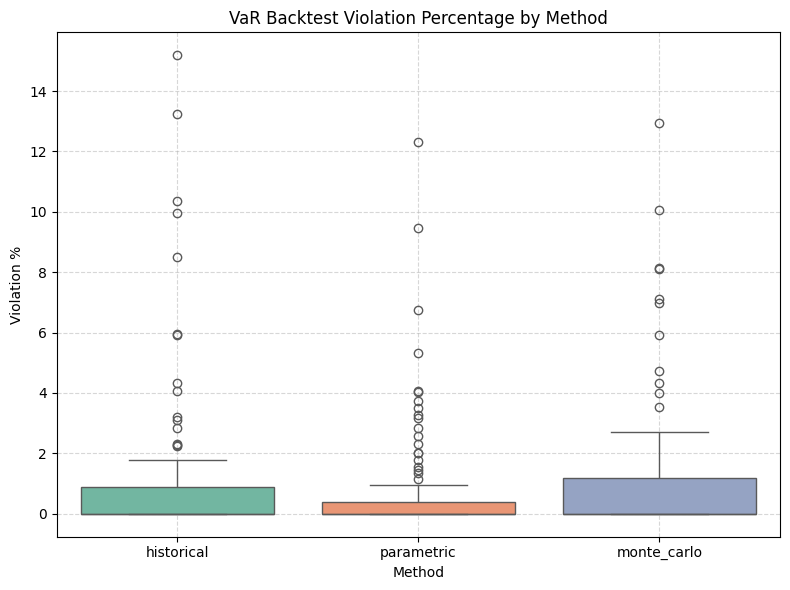

In [34]:
df = pd.DataFrame(results_dict)
df_long = df.melt(var_name='Method', value_name='Violation %')

# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_long, x='Method', y='Violation %', palette='Set2')
plt.title('VaR Backtest Violation Percentage by Method')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

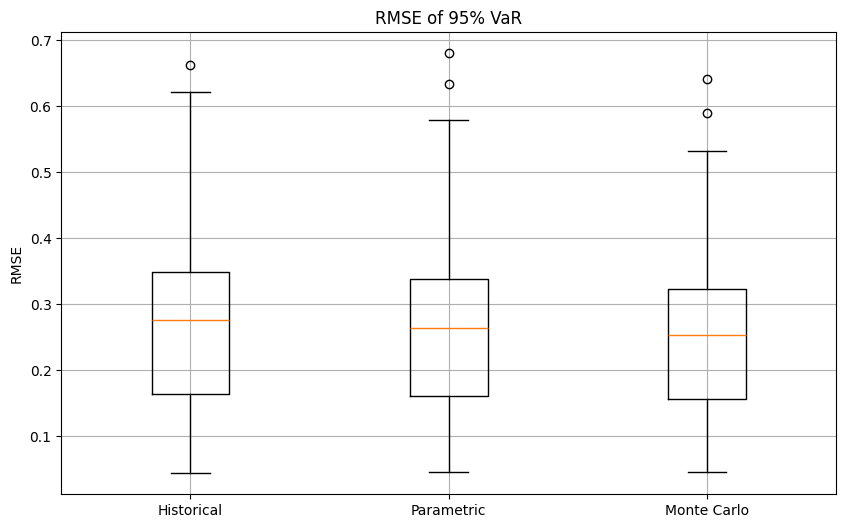

In [35]:
plt.figure(figsize=(10, 6))
plt.boxplot(
    [rmse_dict['historical'], rmse_dict['parametric'], rmse_dict['monte_carlo']],
    labels=['Historical', 'Parametric', 'Monte Carlo']
)
plt.title('RMSE of 95% VaR')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


In [36]:
results_dict = {
    'historical': [],
    'parametric': [],
    'monte_carlo': []
}


rmse_dict = {
    'historical': [],
    'parametric': [],
    'monte_carlo': []
}

cnt = 0
for portofolio in portofolios[:]:
    cnt+=1
    print(f'{cnt} done')
    backtest_results = backtest_all_var_methods(portofolio, confidence_level=0.99)
    # Each backtest_results is a dictionary with keys 'historical', 'parametric', 'monte_carlo'
    results_dict['historical'].append(backtest_results['historical']['violation_pct'])
    results_dict['parametric'].append(backtest_results['parametric']['violation_pct'])
    results_dict['monte_carlo'].append(backtest_results['monte_carlo']['violation_pct'])

    rmse_dict['historical'].append(backtest_results['historical']['rmse'])
    rmse_dict['parametric'].append(backtest_results['parametric']['rmse'])
    rmse_dict['monte_carlo'].append(backtest_results['monte_carlo']['rmse'])

1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done
100 done


In [37]:
np.sum(backtest_results['monte_carlo']['violations'])

np.int64(0)

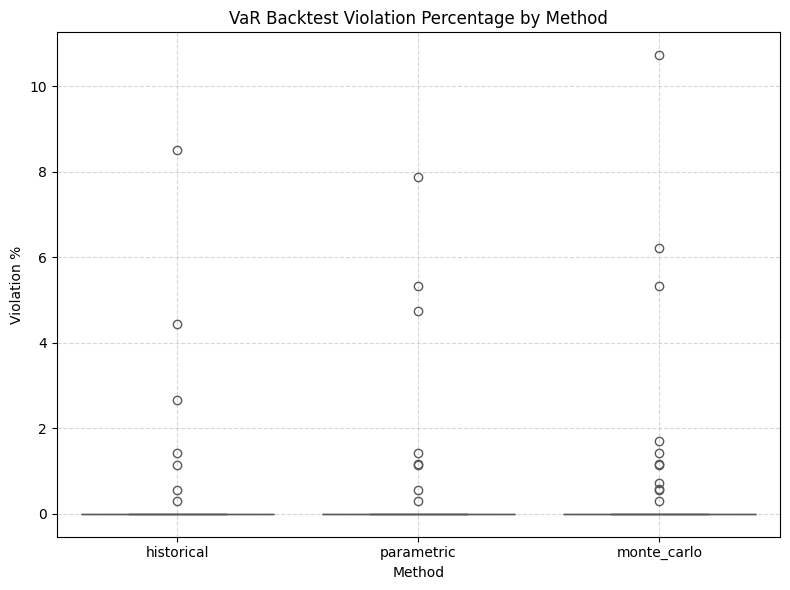

In [38]:
df = pd.DataFrame(results_dict)
df_long = df.melt(var_name='Method', value_name='Violation %')

# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_long, x='Method', y='Violation %', palette='Set2')
plt.title('VaR Backtest Violation Percentage by Method')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

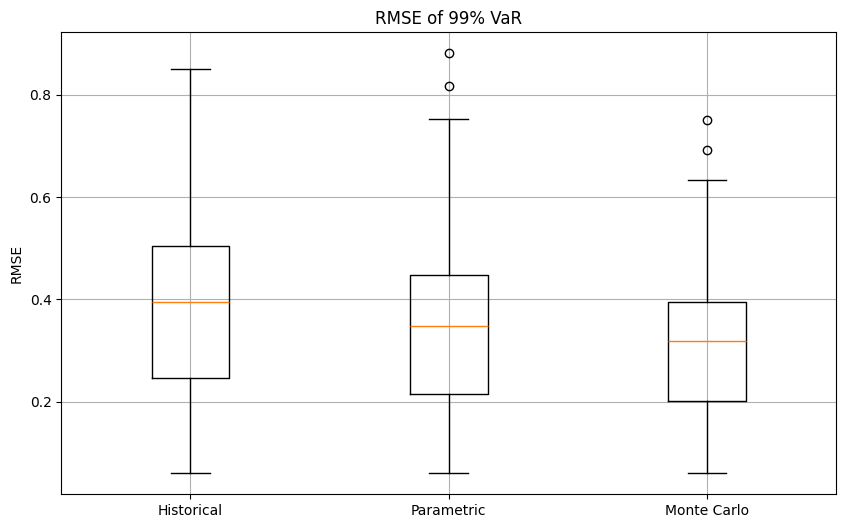

In [39]:
plt.figure(figsize=(10, 6))
plt.boxplot(
    [rmse_dict['historical'], rmse_dict['parametric'], rmse_dict['monte_carlo']],
    labels=['Historical', 'Parametric', 'Monte Carlo']
)
plt.title('RMSE of 99% VaR')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


In [40]:
for method in rmse_dict.keys():
    for i in range(len(rmse_dict[method])):
        if rmse_dict[method][i]:
            print(f'{method} has {rmse_dict[method][i]} at index {i}')


historical has 0.3874032366642722 at index 0
historical has 0.3768957273075068 at index 1
historical has 0.6003294753887081 at index 2
historical has 0.4158069177428399 at index 3
historical has 0.16234403203589973 at index 4
historical has 0.6107175636329311 at index 5
historical has 0.4998520602385796 at index 6
historical has 0.37493525442740344 at index 7
historical has 0.07650441748585568 at index 8
historical has 0.3058783771999377 at index 9
historical has 0.8388466619059156 at index 10
historical has 0.42532472704491314 at index 11
historical has 0.6416530533194186 at index 12
historical has 0.4588871474938068 at index 13
historical has 0.31463347353370563 at index 14
historical has 0.16593829702816593 at index 15
historical has 0.4601258116418912 at index 16
historical has 0.584158975532692 at index 17
historical has 0.5201592263829987 at index 18
historical has 0.3718886500194768 at index 19
historical has 0.5483320453711443 at index 20
historical has 0.09827185954529558 at i

### Custom VaR Model